
# Завдання 2 — Neural Style Transfer (NST)


In [1]:

from pathlib import Path
import torch
import torch.optim as optim
from torchvision import models, transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt

print("Torch:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Torch: 2.9.1+cu128
Device: cpu


Loaded local images.


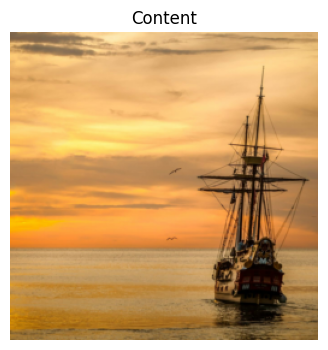

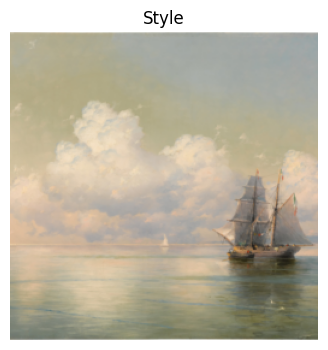

In [2]:

LAB_DIR = Path(r"/home/kali/Downloads/data_anal/lab4")
content_path = LAB_DIR / "content.jpg"
style_path   = LAB_DIR / "style.jpg"

def load_image(path, size=256):
    img = Image.open(path).convert("RGB")
    t = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
    ])
    return t(img).unsqueeze(0)

if content_path.exists() and style_path.exists():
    content_img = load_image(content_path, 256)
    style_img   = load_image(style_path, 256)
    print("Loaded local images.")
else:
    print("Local images not found -> CIFAR fallback (download)")
    cifar = datasets.CIFAR10(
        root=str(LAB_DIR/"cifar10"),
        train=True,
        download=True,
        transform=transforms.Compose([transforms.Resize(256), transforms.ToTensor()])
    )
    content_img, _ = cifar[0]
    style_img, _   = cifar[1]
    content_img = content_img.unsqueeze(0)
    style_img   = style_img.unsqueeze(0)

content_img = content_img.to(device)
style_img   = style_img.to(device)

def show(t, title):
    x = t.detach().cpu().squeeze(0).permute(1,2,0).clamp(0,1)
    plt.figure(figsize=(4,4))
    plt.title(title)
    plt.imshow(x)
    plt.axis("off")
    plt.show()

show(content_img, "Content")
show(style_img, "Style")


In [3]:

vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)
def norm(x): return (x - mean) / std

style_layers = {"0":1.0, "5":0.8, "10":0.6, "19":0.4, "28":0.2}
content_layer = "21"

def gram(t):
    b,c,h,w = t.shape
    f = t.view(b, c, h*w)
    g = torch.bmm(f, f.transpose(1,2))
    return g / (c*h*w)

def feats(x):
    out = {}
    for name, layer in vgg._modules.items():
        x = layer(x)
        if name in style_layers or name == content_layer:
            out[name] = x
    return out


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/kali/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 548M/548M [00:29<00:00, 19.5MB/s]


In [4]:

with torch.no_grad():
    c_feat = feats(norm(content_img))
    s_feat = feats(norm(style_img))
    s_gram = {k: gram(v) for k,v in s_feat.items() if k in style_layers}

generated = content_img.clone().requires_grad_(True)

steps = 120
style_weight = 3e4
content_weight = 1.0

opt = optim.Adam([generated], lr=0.03)

print("NST optimizing...")
for i in range(1, steps+1):
    opt.zero_grad()
    g_feat = feats(norm(generated))

    c_loss = torch.mean((g_feat[content_layer] - c_feat[content_layer])**2)

    s_loss = 0.0
    for layer, w in style_layers.items():
        s_loss = s_loss + w * torch.mean((gram(g_feat[layer]) - s_gram[layer])**2)

    loss = content_weight*c_loss + style_weight*s_loss
    loss.backward()
    opt.step()

    with torch.no_grad():
        generated.clamp_(0, 1)

    if i % 20 == 0 or i == 1:
        print(f"step {i}/{steps} | total={loss.item():.4f} | content={c_loss.item():.4f} | style={s_loss.item():.4f}")

print("Done.")


NST optimizing...
step 1/120 | total=1.3130 | content=0.0000 | style=0.0000
step 20/120 | total=2.0877 | content=0.7533 | style=0.0000
step 40/120 | total=1.1986 | content=0.4993 | style=0.0000
step 60/120 | total=1.0174 | content=0.4374 | style=0.0000
step 80/120 | total=0.9515 | content=0.3975 | style=0.0000
step 100/120 | total=0.9112 | content=0.3992 | style=0.0000
step 120/120 | total=0.8439 | content=0.3429 | style=0.0000
Done.


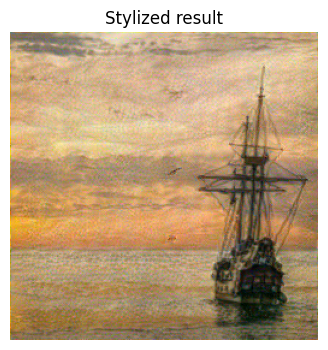

Saved: /home/kali/Downloads/data_anal/lab4/results_task2_nst/nst_result.png


In [5]:

show(generated, "Stylized result")

out_dir = Path("results_task2_nst")
out_dir.mkdir(exist_ok=True)

out_path = out_dir / "nst_result.png"
img = generated.detach().cpu().squeeze(0).permute(1,2,0).numpy()
Image.fromarray((img*255).astype("uint8")).save(out_path)
print("Saved:", out_path.resolve())
